<a href="https://colab.research.google.com/github/sanglic/idal_ia3_uv/blob/main/EJERCICIO_Third_Try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**El objetivo del ejercicio es:**

- Optimizar arquitectura de la red

- Sacar heatmaps

- Partir training en training + validación usando como ejemplo lo que se hacía en el notebook de las caras (carpeta 03-caras)

In [1]:
COLAB = True

Si se desea ejecutar en local:

- Descargar el dataset de training de: https://drive.google.com/file/d/1cc5JyQvS4jJard7YsFKrYnHEcal0Bl6x

- Y el de test de: https://drive.google.com/file/d/1Gv5x1Y6K4JVLambfMBwGbDUDTC0xSQ2r

- Poner variable COLAB a False

In [2]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from glob import glob

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

%matplotlib inline

In [3]:
!ls

sample_data


In [4]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1cc5JyQvS4jJard7YsFKrYnHEcal0Bl6x',
                                        dest_path='./seg_train.zip', unzip=True)
    gdd.download_file_from_google_drive(file_id='1Gv5x1Y6K4JVLambfMBwGbDUDTC0xSQ2r',
                                        dest_path='./seg_test.zip', unzip=True)
    

Unzipping...Done.
Unzipping...Done.


In [5]:
!ls

__MACOSX  sample_data  seg_test  seg_test.zip  seg_train  seg_train.zip


In [6]:
!ls seg_train

buildings  forest  glacier  mountain  sea  street


In [7]:
!ls seg_test

buildings  forest  glacier  mountain  sea  street


In [8]:
!ls seg_train/buildings

0.jpg	   12578.jpg  14916.jpg  17468.jpg  20017.jpg  4600.jpg  7382.jpg
10006.jpg  12590.jpg  14918.jpg  17479.jpg  20027.jpg  4620.jpg  7383.jpg
10014.jpg  125.jpg    14947.jpg  17480.jpg  2002.jpg   4621.jpg  739.jpg
10018.jpg  12602.jpg  14952.jpg  17491.jpg  20048.jpg  4623.jpg  7418.jpg
1001.jpg   12615.jpg  14958.jpg  17495.jpg  20054.jpg  4630.jpg  742.jpg
10029.jpg  12617.jpg  14968.jpg  17503.jpg  2038.jpg   4631.jpg  7439.jpg
10032.jpg  12629.jpg  14984.jpg  17516.jpg  2041.jpg   4634.jpg  7443.jpg
10056.jpg  12632.jpg  14991.jpg  1751.jpg   2043.jpg   463.jpg	 7455.jpg
1009.jpg   12636.jpg  1501.jpg	 17520.jpg  2059.jpg   4667.jpg  7463.jpg
10113.jpg  1263.jpg   15026.jpg  17537.jpg  2069.jpg   4686.jpg  7471.jpg
10126.jpg  12649.jpg  15030.jpg  17539.jpg  2076.jpg   4715.jpg  7478.jpg
1012.jpg   12659.jpg  1503.jpg	 1753.jpg   2083.jpg   4748.jpg  747.jpg
10144.jpg  12668.jpg  15042.jpg  17541.jpg  2088.jpg   4770.jpg  7491.jpg
10151.jpg  12669.jpg  15045.jpg  17545.jpg  20

In [9]:
ficheros = glob("./seg_train/buildings/*")
ficheros[0]

'./seg_train/buildings/4267.jpg'

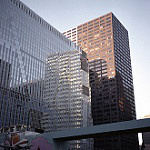

In [10]:
imagen = load_img(ficheros[7])
imagen

In [11]:
imagen.size

(150, 150)

In [12]:
train_data_dir = 'seg_train'
validation_data_dir = 'seg_test'
test_data_dir = 'seg_test'

batch_size = 16

Para ver opciones:

https://keras.io/api/preprocessing/image/#imagedatagenerator-class


In [13]:

# data augmentation:

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen= ImageDataGenerator(rescale=1./255)

In [14]:
###Lee los tados y crea augmentation
#train_generator = train_datagen.flow_from_directory(
#        'seg_train',  # this is the target directory
#        target_size=(150, 150),  # all images will be resized to 150x150
#        batch_size=batch_size,
#        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

In [15]:
#validation_generator = test_datagen.flow_from_directory(
#        'seg_test',
#        target_size=(150, 150),
#        batch_size=batch_size,
#        class_mode='categorical')

In [16]:
imagen_num = np.array([img_to_array(imagen)])

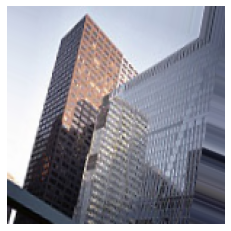

In [17]:
plt.imshow(train_datagen.flow(imagen_num)[0][0])
plt.axis("off");

In [18]:
# dimensiones a las que vamos a llevar las imágenes
img_width, img_height = 150, 150

normed_dims = (img_height, img_width)

In [19]:
normed_dims

(150, 150)

In [20]:
#cmyk convetion
def rgb_to_cmyk(img_arr):
    aaa = []

    img_arr_min = (255 - img_arr)
    K = np.min(img_arr_min, axis=2)

    C_init = (img_arr_min[:, :, 0])
    M_init = (img_arr_min[:, :, 1])
    Y_init = (img_arr_min[:, :, 2])

    C = C_init - K
    M = M_init - K
    Y = Y_init - K

    aaa.append(C)
    aaa.append(M)
    aaa.append(Y)
    aaa.append(K)
    new_arr = np.array(aaa).transpose(1,2,0)
    return new_arr

In [21]:
#def preprocess_input(image):
#  image=np.array(image)
#  #converted_img = rgb_to_cmyk(image)
#  image /= 255
#  converted_img=image
#  return converted_img

In [22]:
def preprocess_input(img):
   img /=255
   mychannel=np.float32(img)[...,:3]
   #x=np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
   #mychannel=np.repeat(x[:, :, np.newaxis], 3, axis=2)
   return mychannel

In [23]:

# sparse_categorical_crossentropy

#building: 0
# 1,0,0,0,0,0

# forest': 1
# 0,1,0,0,0,0

# glacier: 2
# 0,0,1,0,0,0

# mountain: 3
# 0,0,0,1,0,0

# sea: 4,
# 0,0,0,0,1,0

# street: 5
# 0,0,0,0,0,1

In [24]:
from keras.layers import MaxPooling2D
# Definir arquitextura del modelo:



model = Sequential()
model.add(Conv2D(input_shape=(150,150,3),filters=32,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu"))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(6, activation="softmax"))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 73, 73, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 32)        9248      
_________________________________________________________________
dropout (Dropout)            (None, 34, 34, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

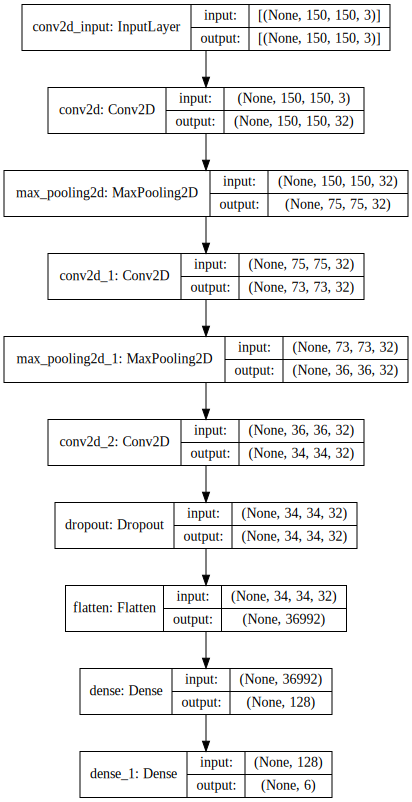

In [26]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

if COLAB:
    display(SVG(model_to_dot(model, show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

In [27]:
train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function = preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen  = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

In [28]:
validation_data_dir, normed_dims

('seg_test', (150, 150))

In [29]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=True,
    class_mode='sparse')

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [30]:
test_datagen.flow_from_dataframe

<bound method ImageDataGenerator.flow_from_dataframe of <tensorflow.python.keras.preprocessing.image.ImageDataGenerator object at 0x7f87879b6668>>

In [31]:
train_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [32]:
number_train_samples = train_generator.n
number_val_samples   = validation_generator.n
number_test_samples  = test_generator.n

number_train_samples, number_val_samples, number_test_samples

(14034, 3000, 3000)

In [33]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [34]:
acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

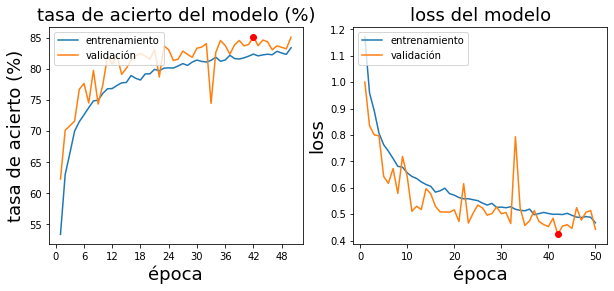

In [35]:
epochs = 50

modelpath="best_model.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                              save_best_only=True,
                              mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]
for e in range(epochs):
    history = model.fit_generator(generator = train_generator, 
                                  steps_per_epoch=number_train_samples // batch_size,
                                  epochs=1,
                                  callbacks=callbacks_list,
                                  verbose=1,
                                  shuffle = True,
                                  validation_data=validation_generator,
                                  validation_steps=number_val_samples // batch_size
                                  )
    
    if history.history['val_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_accuracy'][-1]
    
    acum_tr_acc.append(history.history['accuracy'][0])
    acum_val_acc.append(history.history['val_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [36]:
!ls -la

total 309448
drwxr-xr-x 1 root root      4096 Jan 17 19:30 .
drwxr-xr-x 1 root root      4096 Jan 17 19:27 ..
-rw-r--r-- 1 root root  57112128 Jan 17 20:29 best_model.h5
drwxr-xr-x 1 root root      4096 Jan  8 17:11 .config
drwxr-xr-x 4 root root      4096 Jan 17 19:28 __MACOSX
drwxr-xr-x 1 root root      4096 Jan  6 18:10 sample_data
drwxr-xr-x 8 root root      4096 Jan 17 19:28 seg_test
-rw-r--r-- 1 root root  45638665 Jan 17 19:28 seg_test.zip
drwxr-xr-x 8 root root      4096 Jan 17 19:28 seg_train
-rw-r--r-- 1 root root 214084517 Jan 17 19:28 seg_train.zip


In [37]:
model = load_model(modelpath)

## **Resultados obtenidos**

In [38]:
scores_tr = model.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()

scores_te = model.evaluate(test_generator)
print('Test loss     :', scores_te[0])
print('Test accuracy :', scores_te[1])

878/878 [==============================] - 77s 87ms/step - loss: 0.4678 - accuracy: 0.8268
Train loss    : 0.4678172767162323
Train accuracy: 0.826849102973938

188/188 [==============================] - 3s 17ms/step - loss: 0.4243 - accuracy: 0.8513
Val loss    : 0.4243335723876953
Val accuracy: 0.8513333201408386

188/188 [==============================] - 3s 17ms/step - loss: 0.4243 - accuracy: 0.8513
Test loss     : 0.4243335723876953
Test accuracy : 0.8513333201408386


In [39]:
y_real = test_generator.classes
y_pred_proba = model.predict_generator(test_generator)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [40]:
y_real[:5]

array([0, 0, 0, 0, 0], dtype=int32)

In [41]:
y_pred_proba[:5]

array([[9.9999940e-01, 3.6822898e-15, 1.1414587e-10, 1.3177560e-10,
        2.2900852e-07, 3.6639881e-07],
       [9.7823638e-01, 2.0806283e-04, 2.7101026e-03, 1.8002499e-03,
        1.2528667e-03, 1.5792437e-02],
       [9.1806090e-01, 2.2272788e-08, 2.0235666e-05, 3.2715645e-05,
        5.4208220e-05, 8.1831887e-02],
       [5.8330381e-01, 5.7765692e-03, 4.9924452e-02, 9.6512780e-02,
        5.0845746e-02, 2.1363665e-01],
       [5.7467514e-01, 3.8377143e-04, 1.2951806e-01, 1.4937694e-01,
        4.4930547e-02, 1.0111557e-01]], dtype=float32)

In [42]:
test_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [43]:
num2class = {test_generator.class_indices[x]:x  for x in test_generator.class_indices.keys()}
num2class

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

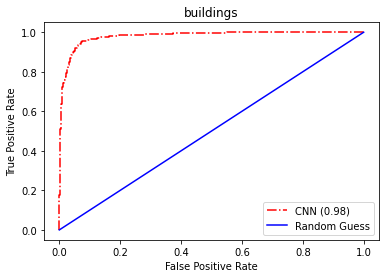

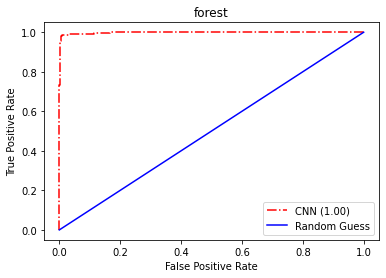

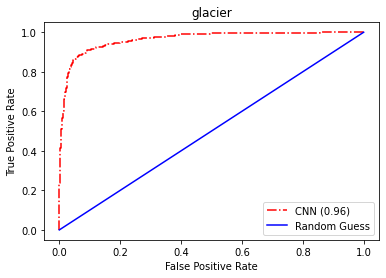

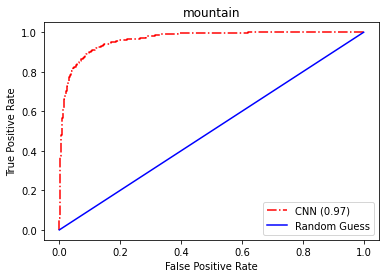

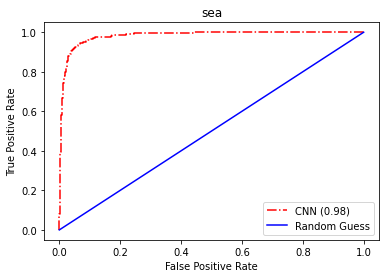

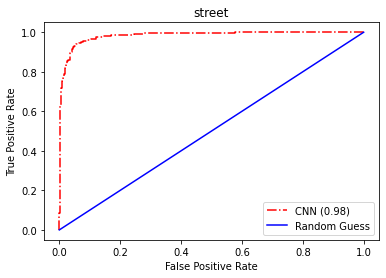

In [44]:
for clase in range(6):
    nombre_clase = num2class[clase]

    fpr, tpr, thresholds = roc_curve(y_real==clase, y_pred_proba[:,clase])
    fig, ax1 = plt.subplots(1,1)
    ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
    ax1.set_title(nombre_clase)
    ax1.legend()
    plt.show()

## **Visualización de ejemplos de test**

In [45]:
test_datagen2 = ImageDataGenerator(dtype='float32')

test_generator2 = test_datagen2.flow_from_directory(
    test_data_dir,
    target_size=normed_dims,
    batch_size=test_generator.n,
    shuffle=False,
    class_mode='sparse')

Found 3000 images belonging to 6 classes.


In [46]:
test_generator2.reset()
X_te, y_te = test_generator2.next()

In [47]:
test_generator2.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [48]:
y_te

array([0., 0., 0., ..., 5., 5., 5.], dtype=float32)

Clase real: buildings
buildings: 99% forest: 0% glacier: 0% mountain: 0% sea: 0% street: 0% 


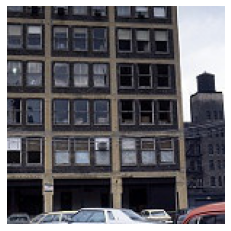

In [49]:
ind_te1 = 130

image = X_te[ind_te1].copy()

print("Clase real:", num2class[y_te[ind_te1]])
plt.imshow(image/255, cmap='jet')
plt.axis("off")
p = model.predict(preprocess_input(np.array([image])))[0]
cadena = ""
for i in range(len(num2class)):
    cadena = cadena + "{}: {}% ".format(num2class[i], int(100*p[i]))
print(cadena)

In [50]:
!ls

best_model.h5  sample_data  seg_test.zip  seg_train.zip
__MACOSX       seg_test     seg_train


In [51]:
# Para descargar el modelo a local:

#from google.colab import files
#files.download('./best_model.h5')